<a href="https://colab.research.google.com/github/jongheonleee/Artificial_Intelligence/blob/master/ch13_tensorflow_basic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 텐서플로를 사용해서 첫 번째 예측 모델을 만들기

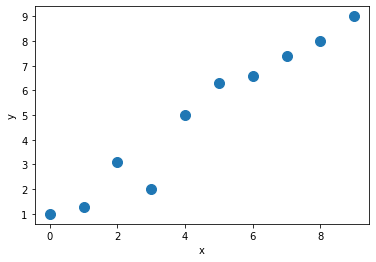

In [2]:
# 선형회귀

# 기초작업: 작은데이터 셋 만들고 산점도로 그려보기
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [4]:
# 특성을 표준화(평균을 원점에 맞추고 표준 편차로 나눔)하고 텐서플로 dataset을 만듦
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))


In [6]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.w = tf.Variable(0.0, name='weight')
    self.b = tf.Variable(0.0, name='bias')

  def call(self, x):
    return self.w * x + self.b

model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [7]:
def loss_fn(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

In [8]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as tape:
    current_loss = loss_fn(model(inputs), outputs)
  dW, db = tape.gradient(current_loss, [model.w, model.b])
  model.w.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

In [12]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train)/ batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
  if i >= steps_per_epoch * num_epochs:
    break
  
  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())

  bx, by = batch
  loss_val = loss_fn(model(bx), by)

  train(model, bx, by, learning_rate=learning_rate)

  if i % log_steps == 0:
    print('에포크 {:3d} 스텝 {:4d} 손실 {:6.4f}'.format(
        int(i/steps_per_epoch), i, loss_val
    ))

에포크   0 스텝    0 손실 43.5600
에포크  10 스텝  100 손실 0.7530
에포크  20 스텝  200 손실 20.1759
에포크  30 스텝  300 손실 23.3976
에포크  40 스텝  400 손실 6.3481
에포크  50 스텝  500 손실 4.6356
에포크  60 스텝  600 손실 0.2411
에포크  70 스텝  700 손실 0.2036
에포크  80 스텝  800 손실 3.8177
에포크  90 스텝  900 손실 0.9416
에포크 100 스텝 1000 손실 0.7035
에포크 110 스텝 1100 손실 0.0348
에포크 120 스텝 1200 손실 0.5404
에포크 130 스텝 1300 손실 0.1170
에포크 140 스텝 1400 손실 0.1195
에포크 150 스텝 1500 손실 0.0944
에포크 160 스텝 1600 손실 0.4670
에포크 170 스텝 1700 손실 2.0695
에포크 180 스텝 1800 손실 0.0020
에포크 190 스텝 1900 손실 0.3612


최종 파라미터: 2.6576622 4.8798566


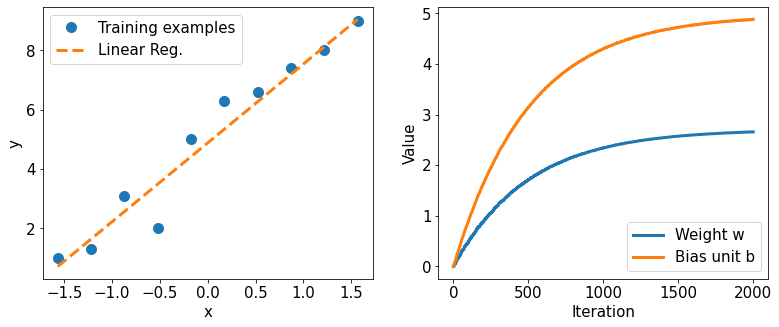

In [13]:
print('최종 파라미터:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# plt.savefig('images/13_6.png', dpi=300)
plt.show()

In [16]:
# .compile()과 .fit() 메서드를 사용한 모델 훈련

tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 [==============================] - 1s 3ms/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 3.9697 - mae: 1.7232 - mse: 3.9697
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 2.7766 - mae: 1.4752 - mse: 2.7766
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 1.9861 - mae: 1.2578 - mse: 1.9861
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 1.4572 - mae: 1.0978 - mse: 1.4572
Epoch 10/200
10/10 [==

2.7067397 4.965721


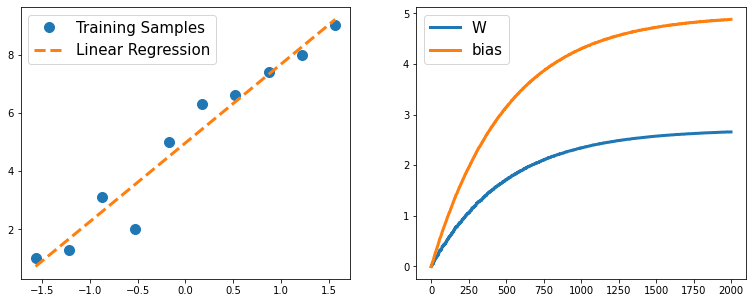

In [24]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

In [25]:
# 붓꽃 데이터셋을 분류하는 다층 퍼셉트로 만들기

import tensorflow_datasets as tfds


iris, iris_info = tfds.load('iris', with_info=True)

print(iris_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/150 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/iris/2.0.0.incompleteRIQUX2/iris-train.tfrecord*...:   0%|          | 0/150 [0…

Dataset iris downloaded and prepared to ~/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='~/tensorflow_datasets/iris/2.0.0',
    file_format=tfrecord,
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    

In [27]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [28]:
## 샘플 개수 확인

n = 0

for example in ds_train_orig:
  n += 1

print(n)

n = 0

for example in ds_test:
  n += 1

print(n)

100
50


In [29]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [30]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [31]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [32]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

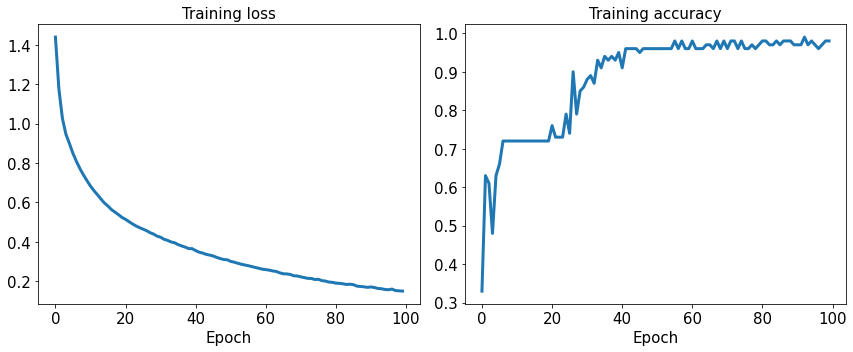

In [35]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig('images/13_7.png', dpi=300)
plt.show()

In [36]:
# 테스트 데이터셋에서 훈련된 모델 평가하기
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1483   테스트 정확도: 0.9800


In [37]:
# 훈련된 모델 저장하고 복원하기


iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [38]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [39]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1483   테스트 정확도: 0.9800


In [40]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('훈련 데이터셋: ',len(labels_train), '테스트 데이터셋: ', len(labels_test))

훈련 데이터셋:  100 테스트 데이터셋:  50


In [41]:
iris_model_new.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 4], "dtype": "float32", "sparse": false, "ragged": false, "name": "fc1_input"}}, {"class_name": "Dense", "config": {"name": "fc1", "trainable": true, "batch_input_shape": [null, 4], "dtype": "float32", "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "fc2", "trainable": true, "dtype": "float32", "units": 3, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regu

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callback_list = [ModelCheckpoint(filepath='iris-earlystopping.h5', 
                                 monitor='val_loss'),
                 EarlyStopping(patience=3, restore_best_weights=True)]


In [43]:
tf.random.set_seed(1)

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list,
                    verbose=0)

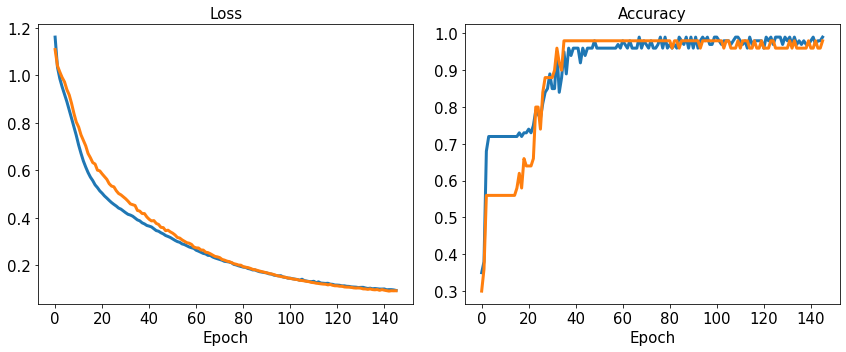

In [44]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.plot(hist['val_loss'], lw=3)
ax.set_title('Loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.plot(hist['val_accuracy'], lw=3)
ax.set_title('Accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig('images/13_earlystopping.png', dpi=300)
plt.show()

In [45]:
callback_list[1].stopped_epoch

145

In [46]:
from tensorflow.keras.callbacks import TensorBoard

callback_list = [ModelCheckpoint(filepath='iris-earlystopping.h5', 
                                 monitor='val_loss'),
                 EarlyStopping(patience=3, restore_best_weights=True),
                 TensorBoard()]

In [47]:
tf.random.set_seed(1)

model = tf.keras.models.model_from_json(iris_model.to_json())
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list,
                    verbose=0)

In [48]:
# 터미널에서 입력하기 > 텐서보드 실행 명령어
# tensorboard --logdir=logs/
# %load_ext tensorboard
# %tensorboard --logdir logs --port 6006

In [49]:
# 다층 신경망의 활성화 함수 선택

# 로지스틱 함수 요약

import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 


P(y=1|x) = 0.888


In [53]:
# W : (n_output_units, n_hidden_units+1) 크기의 배열
# 첫 번째 열은 절편 유닛입니다

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : (n_hidden_units + 1, n_samples) 크기의 배열
# 이 배열의 첫 번째 열은 1입니다

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
print(Z)
y_probas = logistic(Z)
print('최종 입력: \n', Z)

print('유닛 출력:\n', y_probas) 


[1.78 0.76 1.65]
최종 입력: 
 [1.78 0.76 1.65]
유닛 출력:
 [0.85569687 0.68135373 0.83889105]


In [54]:
y_class = np.argmax(Z, axis=0)
print('예측 클래스 레이블: %d' % y_class) 

예측 클래스 레이블: 0


In [55]:
# 소프트맥스 함수를 사용한 다중 클래스 확률 예측
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('확률:\n', y_probas)

np.sum(y_probas)

확률:
 [0.44668973 0.16107406 0.39223621]


1.0

In [56]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)


<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

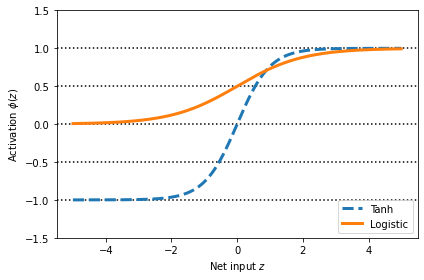

In [57]:
# 하이퍼볼릭 탄젠트로 출력 범위 넓히기

import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/13_8.png', dpi=300)
plt.show()

In [58]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [59]:

import tensorflow as tf

tf.keras.activations.tanh(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

In [60]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [61]:

tf.keras.activations.sigmoid(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

In [62]:
# 렐루 활성화 함수
import tensorflow as tf

tf.keras.activations.relu(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>